## Инициализация

In [10]:
import numpy as np

dt = 0.5
N = 60
t = np.empty(N)

f = lambda x, t: np.matrix([[x[0] + x[1] * t + 4 * t**2/2, x[1] + 4 * t , x[2] + x[3] * t + 5 * t**2/2, x[3] + 5 * t]])

df = lambda x, t: np.matrix([[1, t, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]])

h = lambda x: np.matrix([[x[0] + x[2]]])

dh = lambda x: np.matrix([[1, 0, 1, 0]])

G = np.matrix([[0.87, 0.05, 1.23, 0.05]])

Q = 3

R = np.matrix([[2]])


x_1 = np.empty(4)
P_1 = np.zeros((4, 4))
filterMassive = np.zeros((N, 4))

x_0 = np.array([0, 0, 0, 0])
P_0 = np.matrix([[20, 0, 0, 0], [0, 20, 0, 0], [0, 0, 20, 0], [0, 0, 0, 20]])

In [11]:
# Генерация зашумленного сенсора
istina = np.empty(N)
istina[0] = 0
y = np.empty(N)
t[0] = 0
y[0] = h(x_0)
x_i = x_0
x_ist = x_0
for i in range(1, N):
    t[i] = dt * i
    
    # Для построения настоящих значений сенсора
    x_k_1 = np.array(f(x_i, t[i] - t[i-1])) + np.array(G) * np.random.normal(0, Q) # + с возмущением системы
    x_i = x_k_1[0]
    y[i] = h(x_i) + np.random.normal(0, R) # c шумом от сенсора
    
    
    # Для построения истинных значений сенсора
    x_istina = np.array(f(x_ist, t[i] - t[i-1]))
    x_ist = x_istina[0]
    istina[i] = h(np.array(f(x_ist, t[i] - t[i-1]))[0])

    
r__ = np.empty(len(istina))
for i in range(len(istina)):
    r__[i] = abs(istina[i] - y[i])
print(max(r__))

197.50029500809796


## Расширенный фильтр Калмана

In [13]:
def predict(f, df, t, x_k, P_k, G_k = np.matrix([[0]]), Q_k = np.matrix([[0]])):
    x_k_1 = f(x_k, t)
    P_k_1 = df(x_k, t).dot(P_k).dot(df(x_k, t).T) + (G_k * Q_k).dot(G_k.T) 
    return x_k_1, P_k_1
    
def update(x_k, z_k_1, h, P_k, dH, R_k_1 = np.matrix([[0]])):
    Kk_1 = P_k * dH(x_k).T * np.linalg.inv(dH(x_k)*P_k*dH(x_k).T + R_k_1)
    P_k_1 = (np.diag(np.ones(len(x_k))) - Kk_1 * dH(x_k)) * P_k    
    x_k_1 = x_k.T + Kk_1 * (z_k_1 - h(np.array(x_k)[0]))
    return x_k_1, P_k_1

x = x_0
P = P_0

filterMassive[0] = x_0

for i in range(1, N):
    x_k, P_k = predict(f, df, t[i] - t[i-1], x, P, G, Q)
    x_1, P_1 = update(x_k, y[i], h, P_k, dh, R)
   
    x = np.array(x_1).T[0]
    P = P_1
    filterMassive[i] = np.array(x_1).T[0]

    
filt_y = []
filt_y.append(h(np.array(f(x_0, t[1] - t[0]))[0]))
for i in range(1, N):
    filt_y.append(h(np.array(f(filterMassive[i], t[i] - t[i-1]))[0]))
    

# Results

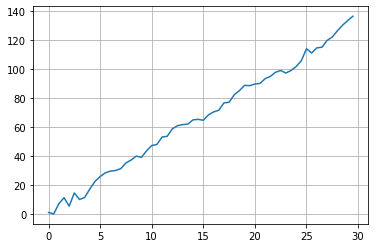

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

filtr = np.empty(N)
for i in range(N):
    filtr[i] = filt_y[i][0]
    
plt.grid()
plt.plot(t, filtr - y)

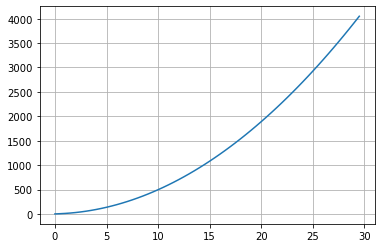

In [15]:
plt.grid()
plt.plot(t, istina)

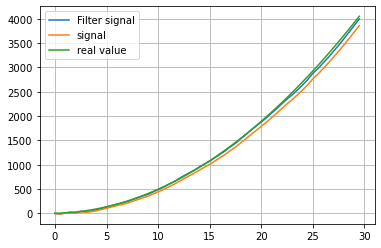

In [16]:
fig, ax = plt.subplots()
plt.grid()
plt.plot(t, filtr, label='Filter signal')
plt.plot(t, y, label='signal')
plt.plot(t, istina, label='real value')
ax.legend()
plt.show()

In [17]:
np.lin

87.65327248073517 23.27378842972063
